In [312]:
import pandas as pd
import math
import datetime
from datetime import date,timedelta
import pandas_datareader.data as web
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

#start date
start = datetime.datetime(2016, 1, 1)

#use up to yesterdays data since day has not ended
yesterday = date.today()- timedelta(1)
end = yesterday.strftime("%Y-%m-%d")

df = web.DataReader("NVDA", 'yahoo', start, end)


In [313]:
#import various regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso,LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [314]:
#Generate some features(X values)
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
len(dfreg)

931

In [315]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

#Separate 10 percent of the data to forecast
forecast_out = int(math.ceil(0.01*len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'

#Y
#dfreg['label'] = dfreg[forecast_col]
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
#y=dfreg['label']
#X
X = np.array(dfreg.drop(['label'], 1))


# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [316]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

#Ridge Regression 3rd order
clfpoly2 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly2.fit(X_train, y_train)

# Lasso Regression
alpha2 = 0.01  #tuning parameter
clfLasso = make_pipeline(PolynomialFeatures(), Lasso(alpha=alpha2))
clfLasso.fit(X_train, y_train)

from sklearn.neighbors import KNeighborsRegressor
#KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [317]:
#Confidence metrics to compare models
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidenceLasso = clfLasso.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

931
2019-09-13 00:00:00


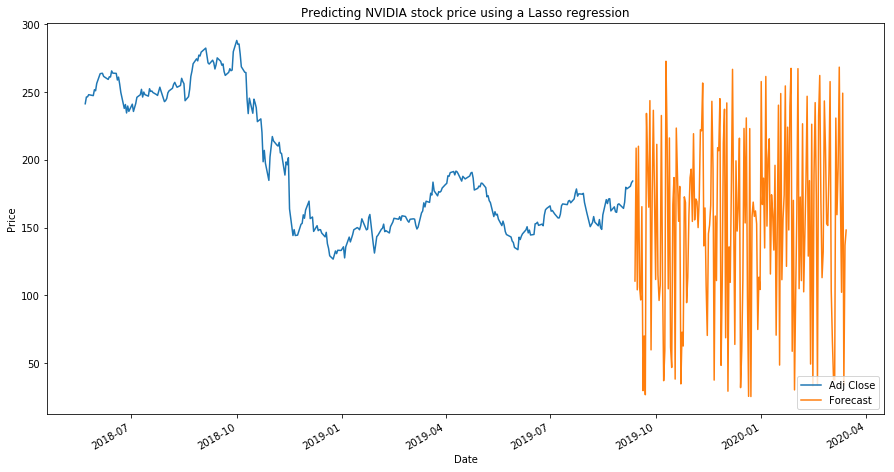

Lasso regression confidence is  0.9577007870075346
Lasso regression RMSE  14.135924079038716


In [318]:
#Lasso
forecast_set3 = clfLasso.predict(X_test)
dfreg['Forecast'] = np.nan
print(len(dfreg['Forecast']))
last_date = dfreg.iloc[-1].name
last_unix = last_date
print(last_unix)
next_unix = last_unix #datetime.timedelta(days=1)
#print(next_unix)
for i in forecast_set3:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
plt.figure(figsize =(15,8))
plt.title('Predicting NVIDIA stock price using a Lasso regression')
dfreg['Adj Close'].iloc[600:929].plot()
dfreg['Forecast'].iloc[929:1200].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
print("Lasso regression confidence is ",confidenceLasso)
mse = mean_squared_error(y_test, forecast_set3) 
rmse3 = np.sqrt(mean_squared_error(y_test,forecast_set3))
print("Lasso regression RMSE ",rmse3)

In [319]:
#Confirm where the last Nan value Is from above
inds = pd.isnull(dfreg['Adj Close']).nonzero()[0]
inds[0]

930

Ridge regression confidence is  0.9361823596013167
Ridge regression RMSE  17.36314658502411


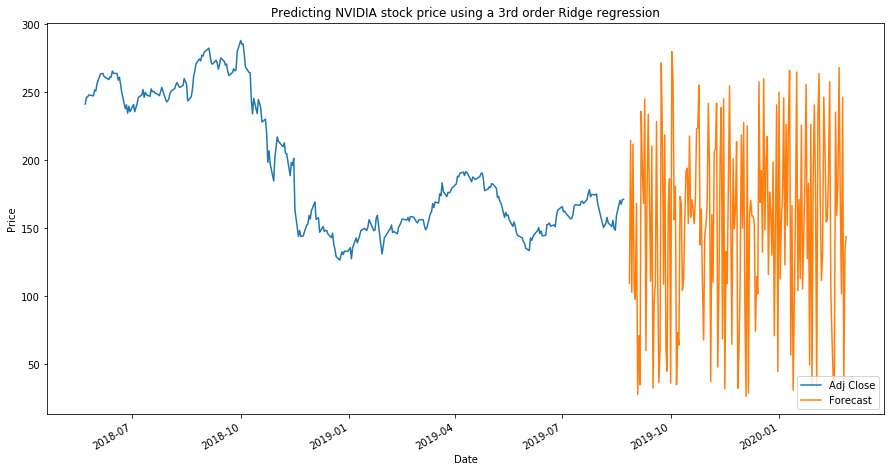

In [320]:
#Ridge Regression Plot and prediction
forecast_set2 = clfpoly2.predict(X_test)
dfreg['Forecast'] = np.nan
last_date2 = dfreg.iloc[-198].name
last_unix2 = last_date2
next_unix2 = last_unix2 + datetime.timedelta(days=1)

for i in forecast_set2:
    next_date2 = next_unix2
    next_unix2 += datetime.timedelta(days=1)
    dfreg.loc[next_date2] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
plt.figure(figsize =(15,8))
plt.title('Predicting NVIDIA stock price using a 3rd order Ridge regression')    
dfreg['Adj Close'].iloc[600:916].plot()
dfreg['Forecast'].iloc[916:1200].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
print("Ridge regression confidence is ", confidencepoly2)
mse = mean_squared_error(y_test, forecast_set2) 
rmse2 = np.sqrt(mean_squared_error(y_test,forecast_set2))
print("Ridge regression RMSE ",rmse2)

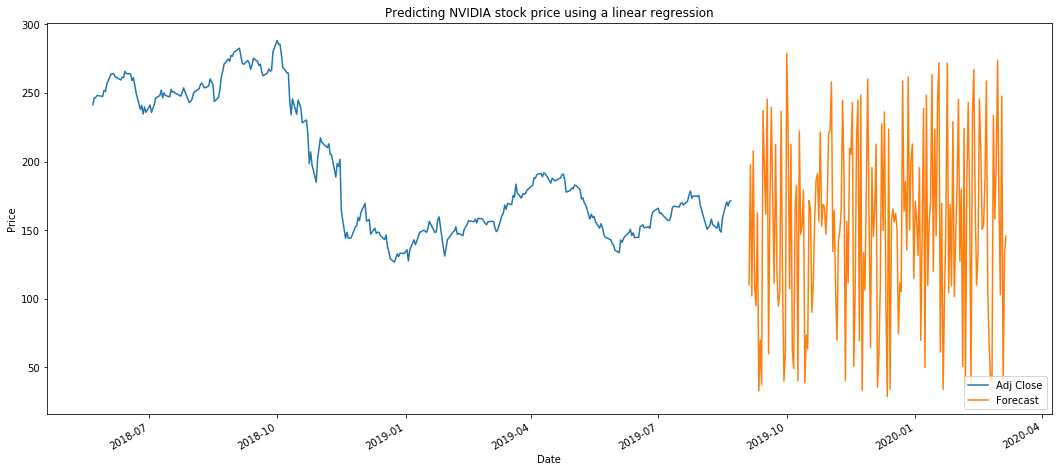

Linear regression confidence is  0.9592060684529315
Linear regression RMSE  13.882121523017096


In [321]:
#Linear Regression plot and prediction
forecast_set1 = clfreg.predict(X_test)
dfreg['Forecast'] = np.nan
last_date1 = dfreg.iloc[-198].name
last_unix1 = last_date1
next_unix1 = last_unix1 + datetime.timedelta(days=1)

for i in forecast_set1:
    next_date1 = next_unix1
    next_unix1 += datetime.timedelta(days=1)
    dfreg.loc[next_date1] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
plt.figure(figsize =(18,8))
plt.title('Predicting NVIDIA stock price using a linear regression') 
dfreg['Adj Close'].iloc[600:916].plot()
dfreg['Forecast'].iloc[916:1200].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
print("Linear regression confidence is ",confidencereg)
mse = mean_squared_error(y_test, forecast_set1) 
rmse1 = np.sqrt(mean_squared_error(y_test,forecast_set1))
print("Linear regression RMSE ",rmse1)

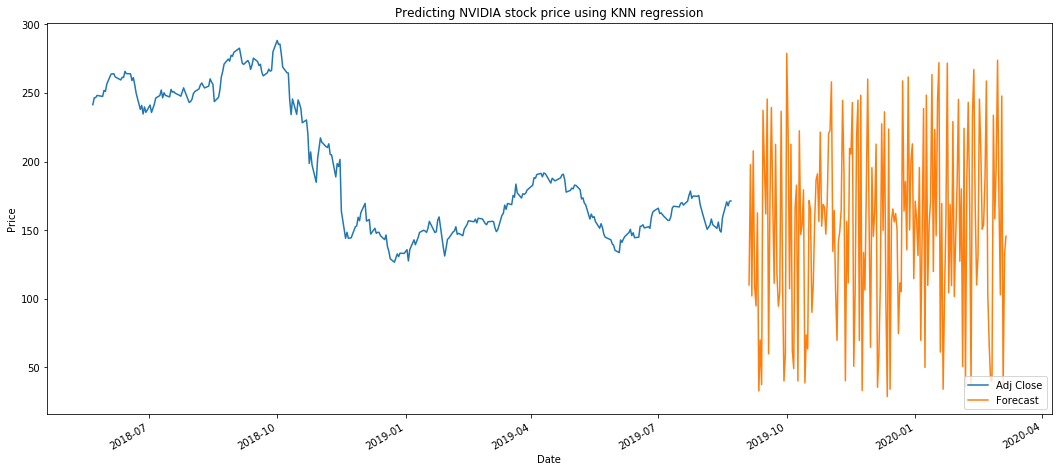

The knn regression confidence is: 0.927428872917484
Linear regression RMSE  18.51569398676384


In [322]:
forecast_set4 = clfknn.predict(X_test)
dfreg['Forecast_knn'] = np.nan

last_date = dfreg.iloc[-26].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)
    
for i in forecast_set4:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg['Forecast_knn'].loc[next_date] = i
plt.figure(figsize =(18,8))
plt.title('Predicting NVIDIA stock price using KNN regression') 
dfreg['Adj Close'].iloc[600:916].plot()
dfreg['Forecast'].iloc[916:1200].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
print('The knn regression confidence is:',confidenceknn)
mse = mean_squared_error(y_test, forecast_set4) 
rmse4 = np.sqrt(mean_squared_error(y_test,forecast_set4))
print("Linear regression RMSE ",rmse4)

In [323]:
#Print Out the Best Model
RMSE_Vals = [rmse4 ,rmse3 ,rmse2 ,rmse1 ]
RMSE_Models = ['Knn','Lasso','Ridge','Linear']
min_rmse = min(RMSE_Vals)
index1 = RMSE_Vals.index(min(RMSE_Vals))
print("The best Model is a",RMSE_Models[index1 ] ,"with RMSE:", min_rmse)

The best Model is a Linear with RMSE: 13.882121523017096
